In [1]:
import numpy as np
from scipy import interpolate
import seaborn as sns
import pylab as plt
import glob, os
import time
import subprocess as spb
import pandas as pd
import scipy
from functools import partial
from hyperopt import hp, tpe,rand, fmin, Trials
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.gridspec as gridspec
markers = ['o', '3', '<', 'v', '^', '>', '1', '2', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D']
line_styles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted','-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
cell_size=3.98597
Zstar=10.0181
factor=1.6*10**3*Zstar/cell_size**3
ps_max=29
ps=ps_max/factor
#size_x,size_y,size_z=96,48,48

In [3]:
def f_K(x,y, T, Tc, stiffness, rho):
    p=rho
    #Tc=305
    bolzman=8.617333262145*1e-5
    stf=stiffness*(Tc-T)
    sigma = 0.5*np.sqrt(48*bolzman*T/stf)#0.5*np.sqrt(48*bolzman/stf*T)
    return 1/(2*np.pi*sigma**2*np.sqrt(1-rho**2))*np.exp(-0.5/(1-p**2)*(x**2-2*p*x*y+y**2)/sigma**2)

def overlap_K(tmeperature, tau0, Tc, d_l, kb, pearson):
    multiple = lambda x,y: f_K(x,y, T=tmeperature, Tc=Tc, stiffness=kb, rho=pearson)
    integ  = 4*scipy.integrate.dblquad(multiple, 0, 10 , lambda x: d_l-x, lambda x: 10)[0]
    if integ == 0:
        return np.inf
    else:
        return tau0/integ

overlap_vec=np.vectorize(overlap_K)
tmeperature,Tc,kb,pearson = 260, 300, 1e-4, 0
multiple = lambda x,y: f_K(x,y, T=tmeperature, Tc=Tc, stiffness=kb, rho=pearson)
4*scipy.integrate.dblquad(multiple,0,10, lambda x: 0, lambda x: 10)[0]

0.6044059087013736

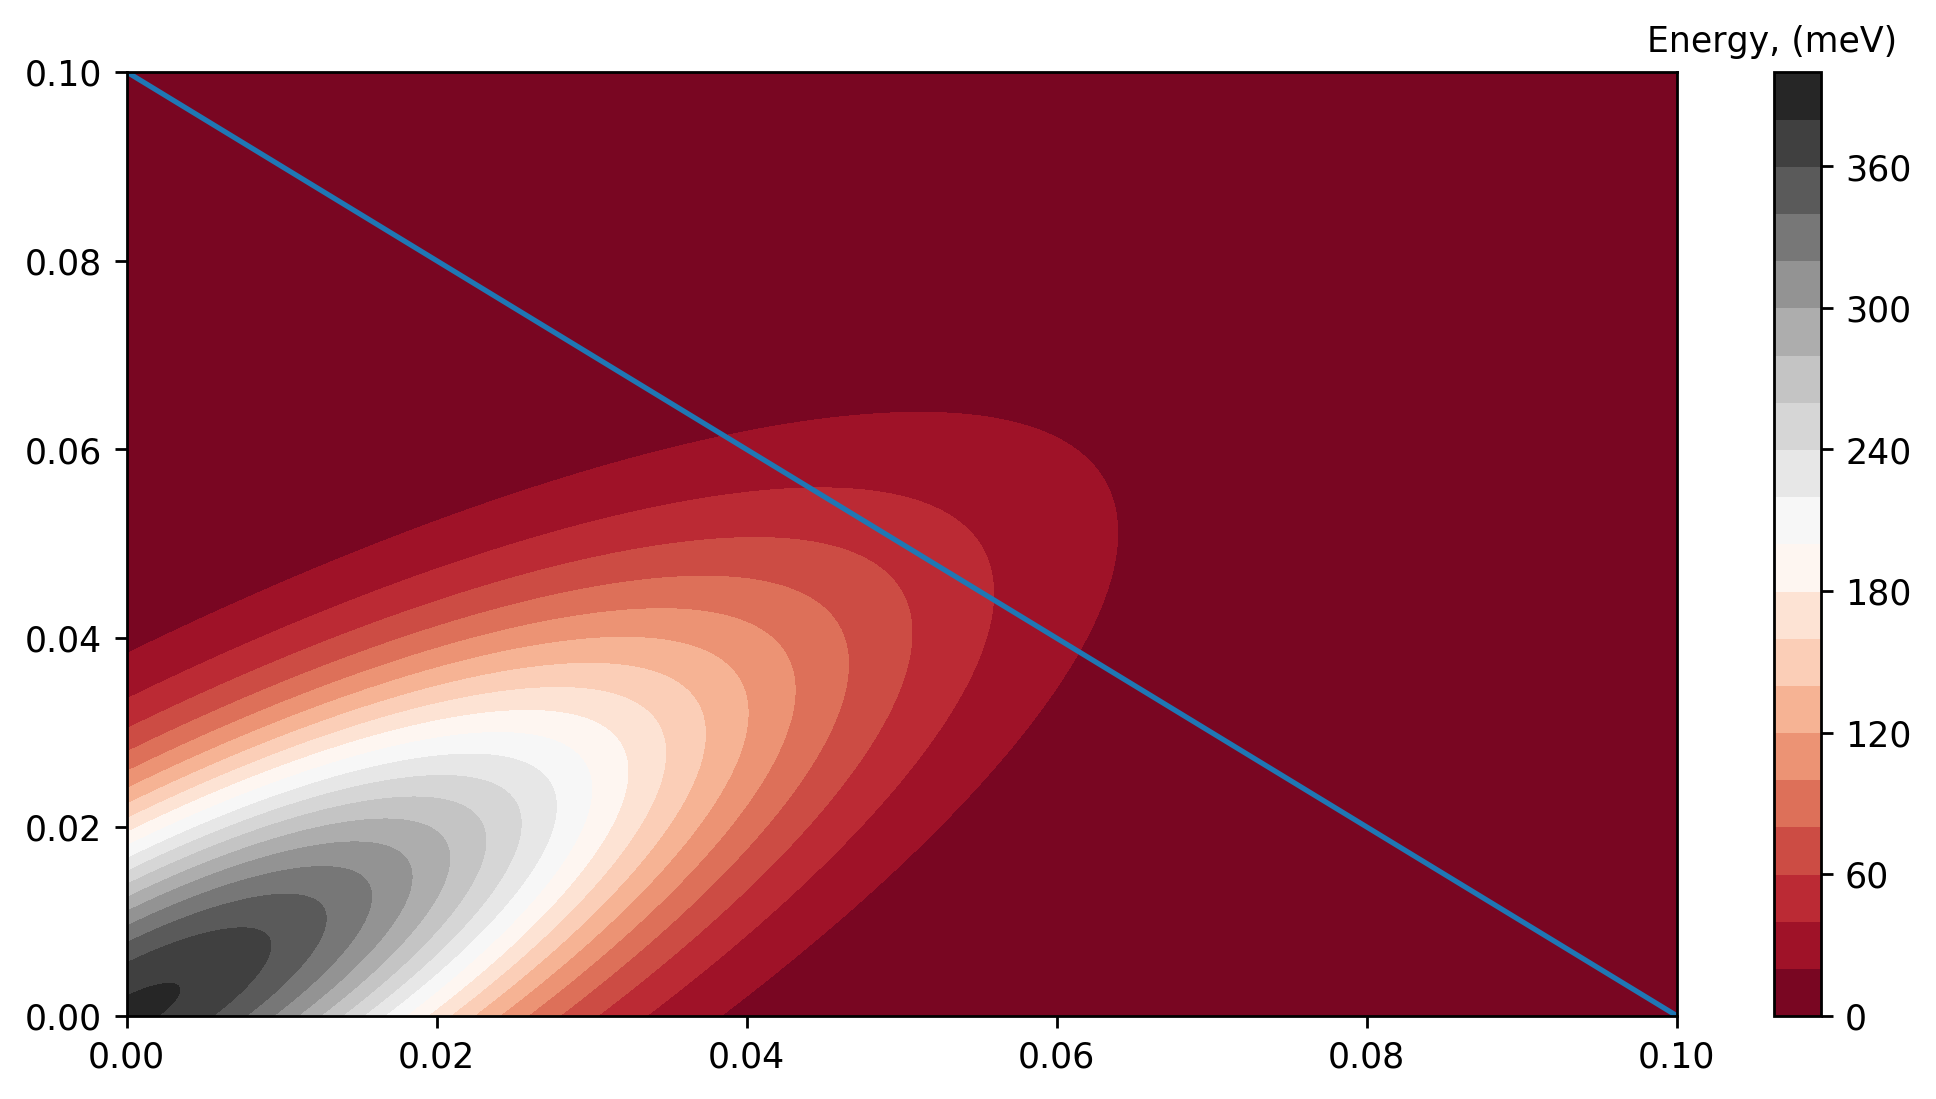

In [8]:
fig = plt.figure(figsize=(10,5), dpi=250)

x=np.linspace(0.0,0.1,1000)
y=np.linspace(0.0,0.1,1000)
X,Y = np.meshgrid(x,y)
Z = f_K(X,Y, 1, 250, 0.006, 0.8)
plt.plot(x, [0.1-i for i in x])
plt.contourf(X, Y, Z, 20, cmap='RdGy')
clb = plt.colorbar()
clb.set_label('Energy, (meV)', labelpad=-40, y=1.05, rotation=0)
plt.savefig('/home/users/khachr91/Desktop/my_papers/PDE_y1_y2_r0_0.8.eps', format='eps')

In [2]:
data=pd.read_csv("/home/users/khachr91/storage/results/DW/DW_thickness/t_start_data.csv")
data_t=data.drop(["Unnamed: 0", "n","T(K)", "attempts"], axis=1).T
data_t=data_t.fillna(data_t.mean())
data_t_s=data_t.T

In [3]:
data

,Unnamed: 0,n,T(K),attempts,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,0,3.0,250.0,17.0,93.0,NaN,163.0,NaN,NaN,117.0,NaN,NaN,183.0,155.0
1,1,3.0,252.0,10.0,82.0,NaN,160.0,NaN,170.0,66.0,67.0,192.0,150.0,128.0
2,2,3.0,254.0,10.0,9.0,58.0,NaN,42.0,110.0,46.0,40.0,70.0,180.0,70.0
3,3,3.0,255.0,10.0,36.0,34.0,50.0,NaN,10.0,NaN,93.0,NaN,NaN,31.0
4,4,3.0,256.0,10.0,98.0,NaN,33.0,20.0,85.0,78.0,43.0,117.0,75.0,67.0
5,5,3.0,258.0,10.0,22.0,3.0,35.0,36.0,2.0,9.0,1.0,5.0,20.0,12.0
6,6,3.0,260.0,10.0,NaN,10.0,10.0,NaN,16.0,NaN,3.0,12.0,3.0,NaN
7,7,4.0,260.0,17.0,34.0,117.0,NaN,NaN,128.0,165.0,50.0,128.0,NaN,168.0
8,8,4.0,265.0,10.0,114.0,64.0,37.0,30.0,81.0,15.0,107.0,50.0,58.0,10.0
9,9,5.0,265.0,16.0,60.0,104.0,160.0,NaN,NaN,NaN,120.0,NaN,94.0,110.0


In [5]:
T6=np.array([270,275,280,285,290])
t6=[np.mean(data_t_s.loc[13]),np.mean(data_t_s.loc[16]),np.mean(data_t_s.loc[18]),np.mean(data_t_s.loc[20]),np.mean(data_t_s.loc[21])]

T5=np.array([265,270,275,280,285])
t5=[np.mean(data_t_s.loc[9]),np.mean(data_t_s.loc[12]),np.mean(data_t_s.loc[15]),np.mean(data_t_s.loc[17]),np.mean(data_t_s.loc[19])]

T4=np.array([260,265,266,270,275])
t4=[np.mean(data_t_s.loc[7]),np.mean(data_t_s.loc[8]),np.mean(data_t_s.loc[10]),np.mean(data_t_s.loc[11]),np.mean(data_t_s.loc[14])]

T3=np.array([250,252,254,255,256,258,260])
t3=[np.mean(data_t_s.loc[0]),np.mean(data_t_s.loc[1]),np.mean(data_t_s.loc[2]),np.mean(data_t_s.loc[3]),np.mean(data_t_s.loc[4]),np.mean(data_t_s.loc[5]),np.mean(data_t_s.loc[6])]

100%|██████████| 100/100 [00:04<00:00, 19.69it/s, best loss: 0.6681965309871352]
[0.5673,299.5337,6.0054,0.0064,0.1210]


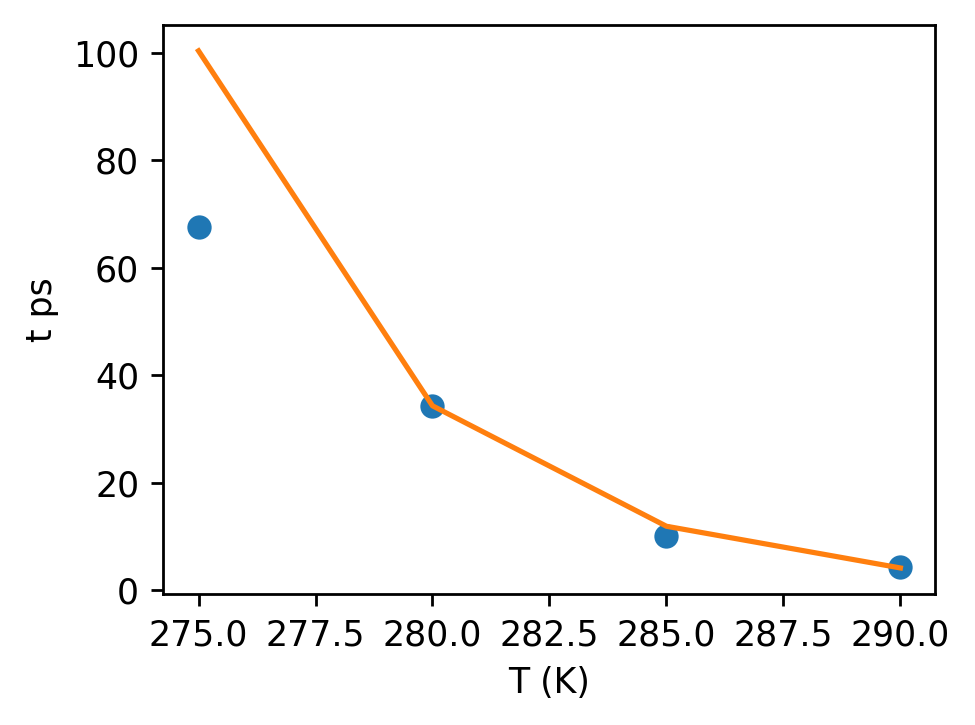

In [93]:
def err_string(args):
    tau0,Tc,d_l,kb,pearson=args
    return np.mean(np.sqrt((overlap_vec(T6[2:], tau0,Tc,d_l,kb,pearson)-np.array(t6)[2:])**2))

corr6=[]
kb6=[]
tc6=[]
trials6 = []
params6 = []
sh_string=[0.5793,300,6,0.0065,0.3110]
for i in range(20):
    trials = Trials()
    space = [hp.uniform('tau0',0.99*sh_string[0],1.01*sh_string[0]),hp.uniform('Tc',299,301),hp.uniform('d_l',5.99,6.01),hp.uniform('kb',0.99*sh_string[3],1.01*sh_string[3]),hp.uniform('pearson',0.8*sh_string[4],1.2*sh_string[4])]
    best_string = fmin(err_string,space,algo=tpe.suggest,max_evals=100, trials=trials)
    sh_string=[best_string["tau0"],best_string["Tc"],best_string["d_l"],best_string["kb"],best_string["pearson"]]
    corr6.append(sh_string[4])
    kb6.append(sh_string[3])
    tc6.append(sh_string[1])
    params6.append(sh_string)
    trials6.append(trials.best_trial['result']['loss'])

fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)

pl.plot(np.array(T6[1:]),np.array(t6[1:]), "o")
pl.plot(T6[1:],overlap_vec(T6[1:], sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]), label = "string")

pl.set_xlabel('T (K)')
pl.set_ylabel('t ps')

print("[{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}]".format(sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]))

100%|██████████| 100/100 [00:05<00:00, 19.66it/s, best loss: 1.7104942270463583]
[0.5535,299.0053,4.9941,0.0065,0.0527]


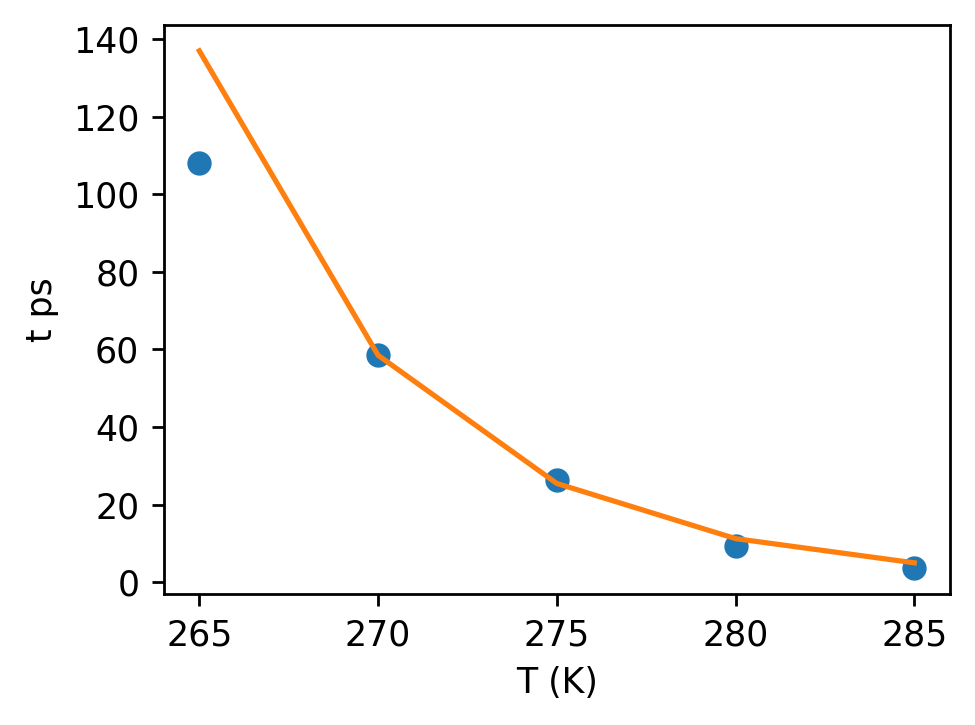

In [94]:
def err_string(args):
    tau0,Tc,d_l,kb,pearson=args
    return np.mean((overlap_vec(T5[1:], tau0,Tc,d_l,kb,pearson)-np.array(t5[1:]))**2)
corr5=[]
kb5=[]
tc5=[]
trials5 = []
params5=[]
sh_string=sh_string=[0.5793,300,5,0.0065,0.07]#[0.5855,298.6132,5,0.0065,0.0735]#

for i in range(20):
    trials = Trials()
    #space = [hp.uniform('tau0',0.8*sh_string[0],1.2*sh_string[0]),hp.uniform('Tc',298,305),hp.uniform('d_l',4.99,5.01),hp.uniform('kb',0.8*sh_string[3],1.2*sh_string[3]),hp.uniform('pearson',0.8*sh_string[4],1.2*sh_string[4])]
    space = [hp.uniform('tau0',0.99*sh_string[0],1.01*sh_string[0]),hp.uniform('Tc',299,301),hp.uniform('d_l',4.99,5.01),hp.uniform('kb',0.99*sh_string[3],1.01*sh_string[3]),hp.uniform('pearson',0.8*sh_string[4],1.2*sh_string[4])]
    best_string = fmin(err_string,space,algo=tpe.suggest,max_evals=100, trials=trials)
    sh_string=[best_string["tau0"],best_string["Tc"],best_string["d_l"],best_string["kb"],best_string["pearson"]]
    corr5.append(sh_string[4])
    kb5.append(sh_string[3])
    tc5.append(sh_string[1])
    trials5.append(trials.best_trial['result']['loss'])
    params5.append(sh_string)

fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)

pl.plot(np.array(T5),np.array(t5), "o")
pl.plot(T5,overlap_vec(T5, sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]), label = "string")

pl.set_xlabel('T (K)')
pl.set_ylabel('t ps')

print("[{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}]".format(sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]))

100%|██████████| 100/100 [00:10<00:00, 10.42it/s, best loss: 4.520491276274296]
[1.2428,299.9113,4.0011,0.0065,0.0004]


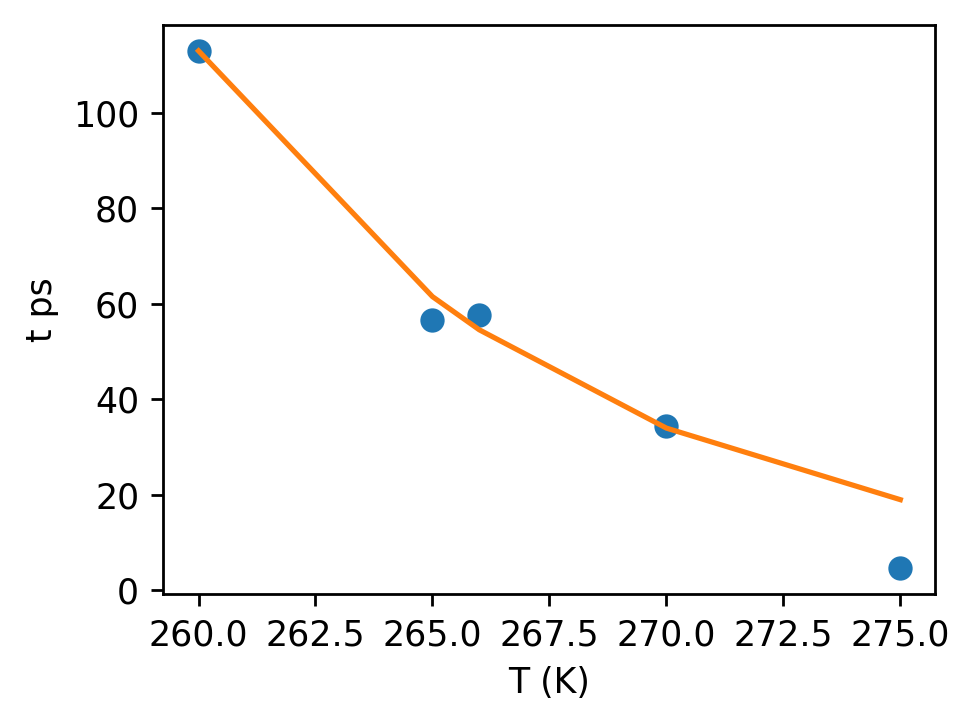

In [120]:
def err_string(args):
    tau0,Tc,d_l,kb,pearson=args
    return np.mean(np.sqrt((overlap_vec(T4, tau0,Tc,d_l,kb,pearson)-np.array(t4))**2))
corr4=[]
kb4=[]
tc4=[]
trials4=[]
params4=[]
sh_string=sh_string=[0.5793,300,4,0.0065,0.0006]#[0.8751,301.9836,4.0019,0.0067,0.0010]
for i in range(20):
    trials = Trials()
    #space = [hp.uniform('tau0',0.999*sh_string[0],1.001*sh_string[0]),hp.uniform('Tc',295,302),hp.uniform('d_l',3.99,5.01),hp.uniform('kb',0.999*sh_string[3],1.001*sh_string[3]),hp.uniform('pearson',0.8*sh_string[4],1.2*sh_string[4])]
    space = [hp.uniform('tau0',0.9*sh_string[0],1.1*sh_string[0]),hp.uniform('Tc',299,301),hp.uniform('d_l',3.99,4.01),hp.uniform('kb',0.999*sh_string[3],1.001*sh_string[3]),hp.uniform('pearson',0.8*sh_string[4],1.2*sh_string[4])]
    best_string = fmin(err_string,space,algo=tpe.suggest,max_evals=100, trials=trials)
    sh_string=[best_string["tau0"],best_string["Tc"],best_string["d_l"],best_string["kb"],best_string["pearson"]]
    corr4.append(sh_string[4])
    kb4.append(sh_string[3])
    tc4.append(sh_string[1])
    trials4.append(trials.best_trial['result']['loss'])
    params4.append(sh_string)

fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)

pl.plot(np.array(T4),np.array(t4), "o")
pl.plot(T4,overlap_vec(T4, sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]), label = "string")

pl.set_xlabel('T (K)')
pl.set_ylabel('t ps')

print("[{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}]".format(sh_string[0],sh_string[1],sh_string[2],sh_string[3],sh_string[4]))

In [100]:
params4=np.array(params4)
params5=np.array(params5)
params6=np.array(params6)

In [101]:
0.5793,301.0694,5,0.0065,0.0006

(0.5793, 301.0694, 5, 0.0065, 0.0006)

In [102]:
np.corrcoef(params4[:,1], trials4)

array([[ 1.        , -0.49164632],
       [-0.49164632,  1.        ]])

In [103]:
np.corrcoef(params5[:,1], trials5)

array([[1.        , 0.37378222],
       [0.37378222, 1.        ]])

In [104]:
np.corrcoef(params6[:,1], trials6)

array([[1.        , 0.88926306],
       [0.88926306, 1.        ]])

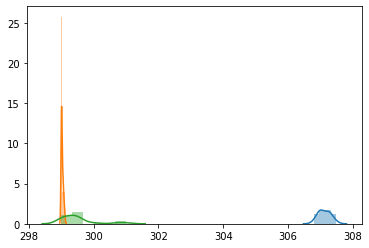

In [105]:
sns.distplot(params4[:,1])
sns.distplot(params5[:,1])
sns.distplot(params6[:,1])

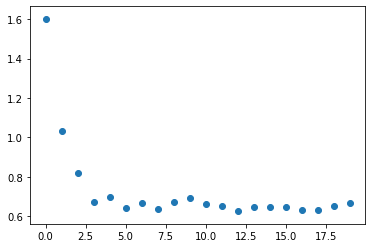

In [108]:
plt.scatter(range(len(trials6)),trials6)

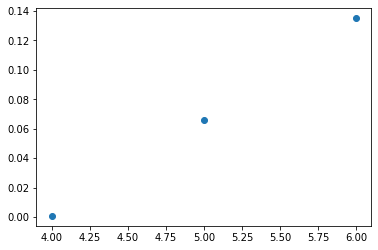

In [119]:
plt.plot([4,5,6],[np.mean(params4[:,-1]),np.mean(params5[:,-1]),np.mean(params6[:,-1])], "o")